In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import tensorflow as tf

from Training_Data.Particle_Tracking_Training_Data import Particle_Tracking_Training_Data

from tensorflow.data import Dataset
import keras
import keras_metrics

from keras.models import Model
from keras.layers import Activation, Input, LeakyReLU, ConvLSTM2D, Conv2D
from tensorflow.keras.optimizers import RMSprop
#from keras.callbacks import EarlyStopping
from keras.models import Sequential

Populating the interactive namespace from numpy and matplotlib


In [2]:
#!pip install keras==2.6.*

# Procedurally generated training data
The code below demonstrates how to generate training videos and labels. The function also returns the ground truth particle tracks, which might also be useful depending on your goals.

Note that the training generator is a Tensorflow Module and can be easily incorperated into a Tensorflow neural network. Alternatively, you could simply save a large set of data and use another machine learning framework.

Note that the image dimension is fixed at 256x256. The labels are downsampled to 128x128 in the image dimensions. There are two classes (a particle is detected or not detected) per label so the label shape is 128x128x2. Hence, the neural network output should be 128x128x2.

### Our paper
https://www.pnas.org/content/115/36/9026.short

In [3]:
Nt = 20 ## number of frames for each video
kappa = 0.2 ## standard deviation of background noise added to image 0.1
a = 1. ## scale factor for the size of particle spots (not true size of particles) 3.0 make random(2.,8.)
IbackLevel = 0.5 ## relative intensity of randomly generated background pattern; in (0, 1) 0.15
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 3. ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 

## Visualizing training videos and labels

In [4]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(121)
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)
    
    fig.add_subplot(122)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')

interactive(children=(IntSlider(value=0, description='t', max=19), Checkbox(value=True, description='show_trac…

### Particle tracks

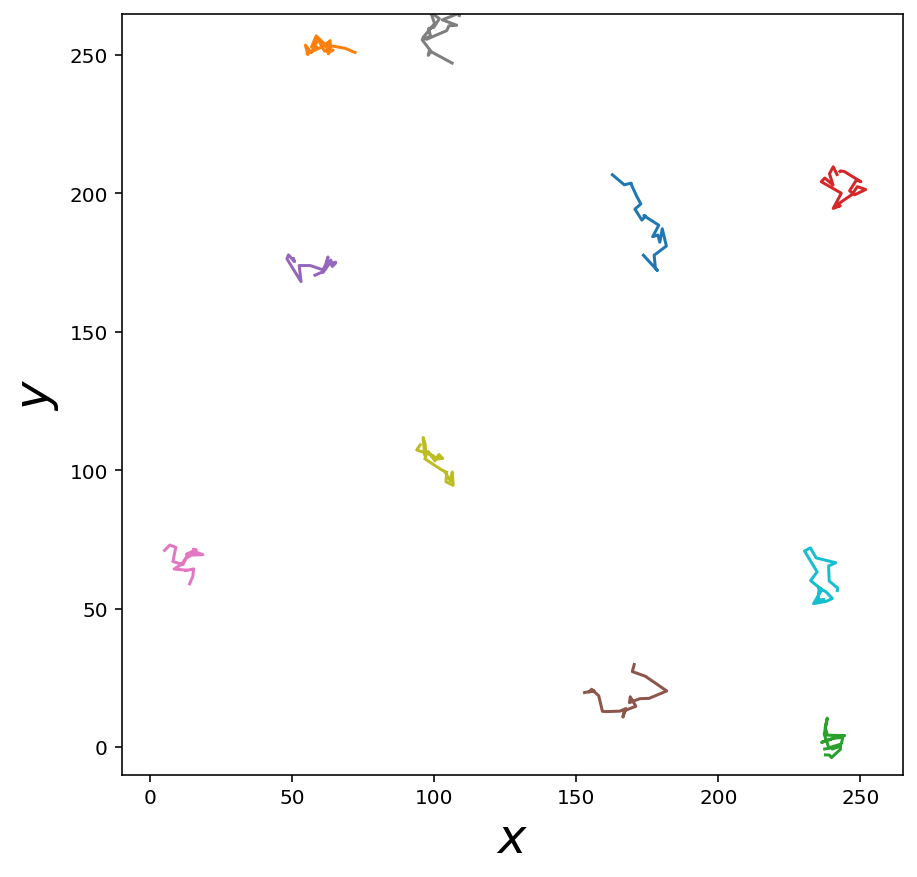

In [5]:
figure(1, [7, 7])
plot(tracks[..., 0], tracks[..., 1])
xlim(-10, 265)
ylim(-10, 265)
xlabel(r'$x$', fontsize=24)
ylabel(r'$y$', fontsize=24);

# Basic CNN

In [7]:
train_size = 200

train_vid, train_labels, train_tracks = [],[],[]
for i in range(train_size): 
    vid, labels, tracks = pt_single(kappa, a, IbackLevel, Nparticles, sigma_motion) 
    train_vid.append(vid[:,::2,::2]) # downsample video to Ntx128x128
    train_labels.append(labels)
    train_tracks.append(tracks)
train_vid = tf.convert_to_tensor(train_vid) 
train_labels = tf.convert_to_tensor(train_labels) 
train_tracks = tf.convert_to_tensor(train_tracks)

train_vid = tf.transpose(train_vid, perm=[0,2,3,1])
train_labels = tf.squeeze(train_labels)#[:,:,:,1]

In [8]:
val_size = 50

val_vid, val_labels, val_tracks = [],[],[]
for i in range(val_size): 
    vid, labels, tracks = pt_single(kappa, a, IbackLevel, Nparticles, sigma_motion) 
    val_vid.append(vid[:,::2,::2]) # downsample video to Ntx128x128
    val_labels.append(labels)
    val_tracks.append(tracks)
val_vid = tf.convert_to_tensor(val_vid) 
val_labels = tf.convert_to_tensor(val_labels) 
val_tracks = tf.convert_to_tensor(val_tracks)

val_vid = tf.transpose(val_vid, perm=[0,2,3,1])
val_labels = tf.squeeze(val_labels)#[:,:,:,1]

In [9]:
import tensorflow.python.keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
total_items = 200
batch_size = 10
epochs = 5

model = Sequential()
model.add(Input((128,128,1)))
model.add(Conv2D(12, 3, padding='same', activation=LeakyReLU(alpha=0.01), strides=(1,1)))
model.add(Conv2D(32, 3, padding='same', activation=LeakyReLU(alpha=0.01), strides=(1,1)))
model.add(Conv2D(2, 3, padding='same', strides=(1,1)))
model.add(Activation('softmax'))

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy', f1_metric, keras_metrics.precision(), keras_metrics.recall()])

num_batches = int(total_items/batch_size)
train_data_generator = single_input_fn(total_items, epochs)
model.fit(train_vid, train_labels, steps_per_epoch=num_batches, epochs=epochs, verbose=1, 
          validation_data=(val_vid, val_labels))#, class_weight={0: 0.1, 1: 0.9})#, callbacks=[tensorboard_callback])

Epoch 1/5
20/20 [==============================] - 6s 279ms/step - loss: 6.6574 - accuracy: 0.9962 - f1_metric: 0.9962 - precision: 0.9964 - recall: 0.9998 - val_loss: 3.6102 - val_accuracy: 0.9959 - val_f1_metric: 0.9959 - val_precision: 0.9964 - val_recall: 0.9998
Epoch 2/5
20/20 [==============================] - 5s 270ms/step - loss: 2.4552 - accuracy: 0.9958 - f1_metric: 0.9958 - precision: 0.9964 - recall: 0.9997 - val_loss: 2.0370 - val_accuracy: 0.9956 - val_f1_metric: 0.9956 - val_precision: 0.9964 - val_recall: 0.9996
Epoch 3/5
20/20 [==============================] - 5s 270ms/step - loss: 1.4854 - accuracy: 0.9958 - f1_metric: 0.9958 - precision: 0.9964 - recall: 0.9995 - val_loss: 1.3767 - val_accuracy: 0.9958 - val_f1_metric: 0.9959 - val_precision: 0.9964 - val_recall: 0.9995
Epoch 4/5
20/20 [==============================] - 6s 281ms/step - loss: 1.0705 - accuracy: 0.9959 - f1_metric: 0.9959 - precision: 0.9964 - recall: 0.9995 - val_loss: 1.1987 - val_accuracy: 0.9964 -

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 12)      120       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      3488      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 2)       578       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 2)       0         
Total params: 4,186
Trainable params: 4,186
Non-trainable params: 0
_________________________________________________________________


In [13]:
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [162]:
%tensorboard --logdir logs/scalars

UsageError: Line magic function `%tensorboard` not found.


# ConvLSTM2D

In [14]:
train_size = 10
Nt = 20
pt = Particle_Tracking_Training_Data(Nt)

train_vid, train_labels, train_tracks = [],[],[]
for i in range(train_size): 
    vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 
    train_vid.append(vid[:,::2,::2]) # downsample video to Ntx128x128
    train_labels.append(labels)
    train_tracks.append(tracks)
train_vid = tf.convert_to_tensor(train_vid) 
train_labels = tf.convert_to_tensor(train_labels) 
train_tracks = tf.convert_to_tensor(train_tracks)

train_vid = tf.expand_dims(train_vid, 4)
train_labels = tf.squeeze(train_labels)

In [15]:
val_size = 5

val_vid, val_labels, val_tracks = [],[],[]
for i in range(val_size): 
    vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 
    val_vid.append(vid[:,::2,::2]) # downsample video to Ntx128x128
    val_labels.append(labels)
    val_tracks.append(tracks)
val_vid = tf.convert_to_tensor(val_vid) 
val_labels = tf.convert_to_tensor(val_labels) 
val_tracks = tf.convert_to_tensor(val_tracks)

val_vid = tf.expand_dims(val_vid, 4)
val_labels = tf.squeeze(val_labels)

In [16]:
total_items = train_size
batch_size = 5
epochs = 5

model = Sequential()
model.add(Input((Nt,128,128,1)))
model.add(ConvLSTM2D(12, kernel_size=(3, 3), padding='same', strides=(1,1), 
                     return_sequences=True,  data_format='channels_last'))
model.add(ConvLSTM2D(16, kernel_size=(3, 3), padding='same', strides=(1,1), 
                     return_sequences=True,  data_format='channels_last'))
model.add(ConvLSTM2D(2, kernel_size=(3, 3), padding='same', strides=(1,1), 
                     return_sequences=True,  data_format='channels_last'))
model.add(Activation('softmax'))

model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', f1_metric, keras_metrics.precision(), keras_metrics.recall()])

num_batches = int(total_items/batch_size)
train_data_generator = single_input_fn(total_items, epochs)
model.fit(train_vid, train_labels, steps_per_epoch=num_batches, epochs=epochs, verbose=1, 
          validation_data=(val_vid, val_labels))#, callbacks=[tensorboard_callback])

Epoch 1/5
2/2 [==============================] - 69s 34s/step - loss: 0.6820 - accuracy: 0.6586 - f1_metric: 0.6586 - precision: 0.9965 - recall: 0.4946 - val_loss: 0.6239 - val_accuracy: 0.9963 - val_f1_metric: 0.9963 - val_precision: 0.9965 - val_recall: 0.7731
Epoch 2/5
2/2 [==============================] - 33s 18s/step - loss: 0.6066 - accuracy: 0.9961 - f1_metric: 0.9961 - precision: 0.9965 - recall: 0.8467 - val_loss: 0.5589 - val_accuracy: 0.9966 - val_f1_metric: 0.9966 - val_precision: 0.9964 - val_recall: 0.8865
Epoch 3/5
2/2 [==============================] - 33s 18s/step - loss: 0.5477 - accuracy: 0.9963 - f1_metric: 0.9963 - precision: 0.9964 - recall: 0.9088 - val_loss: 0.5191 - val_accuracy: 0.9966 - val_f1_metric: 0.9966 - val_precision: 0.9964 - val_recall: 0.9243
Epoch 4/5
2/2 [==============================] - 32s 18s/step - loss: 0.5121 - accuracy: 0.9963 - f1_metric: 0.9963 - precision: 0.9964 - recall: 0.9350 - val_loss: 0.4916 - val_accuracy: 0.9966 - val_f1_metr

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 20, 128, 128, 12)  5664      
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 20, 128, 128, 16)  16192     
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 20, 128, 128, 2)   1304      
_________________________________________________________________
activation_2 (Activation)    (None, 20, 128, 128, 2)   0         
Total params: 23,160
Trainable params: 23,160
Non-trainable params: 0
_________________________________________________________________
